In [456]:
import requests
import time
from bs4 import BeautifulSoup
import random
import pandas as pd
import re
from IPython.display import display, HTML
import urllib.parse

# Job Scraping

In [457]:
# Title of job in search
title = "Data Scientist"
encoded_job_title = title.replace(" ", "%2B")

# Location
location = "Los Angeles County"
encoded_location = location.replace(" ", "%2B")

# Start position, goes by 10
start_position = 0

# Number of jobs to search
num_jobs = 200



In [458]:
# link for list of job postings on the left on linkedin

all_jobs = []

for start_position in range(0, num_jobs + 1, 10):
    list_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={encoded_job_title}&location={encoded_location}&geoId=&trk=public_jobs_jobs-search-bar_search-submit&start={start_position}"
    response = requests.get(list_url)

    if response.status_code == 200:
        list_data = response.text
        list_soup = BeautifulSoup(list_data, "html.parser")
        more_jobs = list_soup.findAll("li")
        all_jobs.extend(more_jobs)
    else:
        print(f"Failed to retrieve data for start_position={start_position}. Status code: {response.status_code}")
        break  

# Print the total number of jobs found
print(f"Total jobs found: {len(all_jobs)}")




/var/folders/4p/b0r7rdfn5rn__y6drcc8f5m80000gn/T/ipykernel_49883/1263363178.py:12: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  more_jobs = list_soup.findAll("li")


Total jobs found: 210


In [459]:
job_id_list = []

for job in all_jobs:
    # find job_ids
    base_card_div = job.find("div", {"class": "base-card"})
    if base_card_div:  
        job_id = base_card_div.get("data-entity-urn", "")
        if job_id:
            job_id = job_id.split(":")[3]  # Extract ID
            job_id_list.append(job_id)
    else:
        continue
job_id_list = set(job_id_list)
print(len(job_id_list))

206


In [460]:
def clean_description(description):
    if description:
        description = description.text
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', description)
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        
        # Trim leading and trailing spaces
        text = text.strip()

        return text
        


In [461]:
job_list = []

for job_id in job_id_list:
    job_url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"
    job_response = requests.get(job_url)

    # Too many requests will cause error
    if job_response.status_code == 429:
        time.sleep(5)  # Wait for 60 seconds (or more based on LinkedIn's rate limit policy)
        job_response = requests.get(job_url)

    job_soup = BeautifulSoup(job_response.text, "html.parser")

    # Dictionary for each job posting
    job_post = {}
    
    # Clean description used to parse for fields
    raw_description = job_soup.find("div", {"class": "description__text description__text--rich"})
    cleaned_desc = clean_description(raw_description)

    # Check Response
    job_post["response"] = job_response.status_code

    # listing ID
    job_post["id"] = job_id
    
    # time posted
    try:
        job_post["time_posted"] = job_soup.find("span", {"class": "posted-time-ago__text topcard__flavor--metadata"}).text.strip()
    except:
        job_post["time_posted"] = None
    # company name
    try:
        job_post["company_name"] = job_soup.find("a",{"class": "topcard__org-name-link topcard__flavor--black-link"}).text.strip()
    except:
        job_post["company_name"] = None
    
    # company location
    try: 
        job_post["location"] = job_soup.find("span", {"class": "topcard__flavor topcard__flavor--bullet"}).text.strip()
    except:
        job_post["location"] = None
    
    # Role Title
    try:
        job_post["title"] = job_soup.find("h2", {"class":"top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title"}).text.strip()
    except:
        job_post["title"] = None

    # Seniority Level
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        sen_level = level_header.find_next_sibling("span").text.strip()
        job_post["seniority_level"] = sen_level
    except:
        job_post["seniority_level"] = None
        
    # Employment Type (Fulltime, Part-time, internship)
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        emp_header = level_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        emp_type = emp_header.find_next_sibling("span").text.strip()
        job_post["employment_type"] = emp_type
        
    except:
        job_post["job_type"] = "Job type not specified"
    
    # Years of Experience
    try:
        pattern = r'(\d+)(?:\+|\-?\d*)\s*years?'
        matches = re.findall(pattern, raw_description.text)
        if matches:
            numbers = [match for match in matches]
            if min(numbers) == '18':
                job_post["yoe"] = None
            else:
                job_post["yoe"] = min(numbers)
        else:
            job_post["yoe"] = None
    except:
        job_post["yoe"] = None

    # Degree Required - format as a list if mulitple degrees

    try:
        pattern = r"(?i)\b(bachelor[’']?s|master[’']?s|ph\.?d|doctorate|b\.?s\.?|m\.?s\.)\b"
        edu = re.findall(pattern, cleaned_desc)
        
        edu = [match.lower().replace("’", "'") for match in edu]
        degree_map = {"bs": "bachelor's", "ms": "master's", "b.s": "bachelor's", "m.s": "master's"}
        formatted_matches = [degree_map.get(match, match) for match in edu]
        degrees = list(set(formatted_matches))
        
        
        if len(degrees) > 1:
            result = " or ".join(degrees)
        else:
            result = degrees[0] if degrees else None
        
        job_post["education"] = result
    except:
        job_post["education"] = None

    # Salary
    try:
        salary_div = job_soup.find("div", {"class": "salary compensation__salary"})
        if salary_div:  
            job_post["salary"] = salary_div.text.strip()
        else:
            if raw_description and hasattr(raw_description, 'text'):  # Check if raw_description is not None and has the 'text' attribute
                pattern = r"\$[\d,]+(?:\.\d{2})?\s?-\s?\$[\d,]+(?:\.\d{2})?"
                salary_range = re.findall(pattern, raw_description.text)
                job_post["salary"] = " ".join(salary_range) if salary_range else None
            else:
                job_post["salary"] = None

    except AttributeError as e:
        job_post["salary"] = None

    except:
        job_post["salary"] = None

    # Programming Languages (Python, R, SQL, Java, Scala)
    languages = ['python', 'r', 'sql', 'java', 'scala', 'c++', 'julia', 'matlab', 'dax', 'vba', 'mdx', 'javascript', 'typescript', 'bash', 'shell']

    try:
        pattern = r'\b(?:' + '|'.join(re.escape(lang) for lang in languages) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["programming_languages"] = None
        else:
            job_post["programming_languages"] = matches

    
    except:
        job_post["programming_languages"] = None


    # ML Skills (TensorFlow, PyTorch, Scikit-learn, Keras)
    ml_ai_skills = ['tensorflow', 'pytorch', 'scikit-learn', 'keras', 'xgboost', 'lightgbm', 'catboost', 'fastai', 'mlflow', 'onnx', 'apache mxnet', 
                'hugging face transformers', 'nltk', 'spacy', 'gensim', 'faiss', 'sentence-transformers', 'h2o.ai', 'deepchem', 
                'supervised learning', 'unsupervised learning', 'reinforcement learning', 'graph neural networks', 'computer vision', 
                'nlp', 'bayesian networks', 'logistic regression', 'linear regression', 'decision trees', 'random forest', 'gradient boosting', 
                'support vector machines', 'k-means clustering', 'hierarchical clustering', 'gaussian mixture models', 'hidden markov models', 
                'principal component analysis', 'singular value decomposition', 'time-series forecasting', 'anomaly detection', 'jax', 'genai', 'generativeai']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in ml_ai_skills) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["ml_skills"] = None
        else:
            job_post["ml_skills"] = matches

    
    except:
        job_post["ml_skills"] = None

    # Data Processing & Databases (ETL, Pandas, Spark, Hadoop, Snowflake)
    data_processing_databases = ['etl', 'pandas', 'spark', 'hadoop', 'snowflake', 'airflow', 'dbt', 'kafka', 'redshift', 'bigquery', 'presto', 
                             'trino', 'hive', 'pig', 'databricks', 'delta lake', 'iceberg', 'hudi', 'cassandra', 'mongodb', 'couchdb', 
                             'neo4j', 'arangodb', 'firebase', 'postgresql', 'mysql', 'mariadb', 'sqlite', 'oracle', 'sql server', 
                             'teradata', 'vertica', 'clickhouse', 'greenplum', 'impala', 'exasol', 'druid', 'tidb', 'scyllaDB', 'rockset', 
                             'elasticsearch', 'splunk', 'opensearch', 'flink', 'beam', 'storm', 'dask', 'modin', 'ray[data]', 
                             'polars', 'duckdb', 'voltdb', 'timestream', 'timescaledb', 'influxdb', 'prometheus', 'graphdb', 
                             'yugabyte', 'foundationdb', 'faunadb', 'cosmos db', 'dynamodb']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in data_processing_databases) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["data_processing_db"] = None
        else:
            job_post["data_processing_db"] = matches

    
    except:
        job_post["data_processing_db"] = None


    # Cloud Platforms (AWS, GCP, Azure, OCI)
    cloud_devops_platforms = ['aws', 'gcp', 'azure', 'oci', 'databricks', 'kubernetes', 'docker', 'terraform', 'cloudformation', 'ansible', 
                          'lambda', 'cloud run', 'sagemaker', 'vertex ai', 'azure ml', 'redshift spectrum', 'biglake', 'synapse', 
                          'athena', 'lake formation', 'snowpark', 'gitlab ci/cd', 'github actions', 'jenkins', 'circleci', 'argo workflows', 
                          'kubeflow', 'mlflow', 'airflow', 'dagster', 'prefect', 'kedro', 'bentoml', 'seldon', 'ray[serve]']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in cloud_devops_platforms) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["cloud"] = None
        else:
            job_post["cloud"] = matches

    
    except:
        job_post["cloud"] = None

    # Visualization Tools (Tableau, Power BI, D3.js)
    visualization_tools = ['tableau', 'power bi', 'd3.js', 'looker', 'superset', 'metabase', 'plotly', 'matplotlib', 'seaborn', 'ggplot2', 
                       'altair', 'vega', 'dash', 'streamlit', 'shiny', 'holoviews', 'bokeh', 'oac']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in visualization_tools) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["visualization"] = None
        else:
            job_post["visualization"] = matches

    
    except:
        job_post["data_processing_db"] = None

    # Big Data Tools (Airflow, Kafka, Kubernetes, Golang)
    big_data_tools = ['airflow', 'kafka', 'kubernetes', 'flink', 'storm', 'beam', 'pulsar', 'druid', 'clickhouse', 'redpanda', 'spark streaming', 'terraform']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in big_data_tools) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["big_data"] = None
        else:
            job_post["big_data"] = matches

    
    except:
        job_post["big_data"] = None

    # product skills
    product_skills = ['a/b testing', 'a/b', 'experimentation', 'causal inference', 'growth analytics', 'product analytics', 
                  'feature engineering', 'model deployment', 'mlops', 'explainability', 'ai ethics', 'privacy-preserving ml']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in product_skills) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["product_skills"] = None
        else:
            job_post["product_skills"] = matches

    
    except:
        job_post["product_skills"] = None

    # Description
    try:
        job_post["description"] = cleaned_desc
        
    except:
        job_post["description"] = None
    

    job_list.append(job_post)

In [462]:
jobs_df = pd.DataFrame(job_list)
jobs_df


,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description
0,200,4104523151,2 months ago,Caltech,"Pasadena, CA",Data Scientist for Enrollment Management,Entry level,Full-time,None,masters,"$129,200.00/yr - $160,000.00/yr","[python, sql, r]",None,None,None,None,None,None,caltech is a worldrenowned science and enginee...
1,200,4165792372,2 weeks ago,Share Ventures,"Los Angeles, CA",Senior Backend/AI Engineer,Mid-Senior level,Full-time,None,None,None,[python],None,None,None,None,None,None,about the stealth venture at share ventures we...
2,200,4138405677,1 month ago,Gensler,"Los Angeles, CA",Design Technology Data Scientist,Not Applicable,Full-time,None,masters or bachelors,"$120,000.00/yr - $150,000.00/yr","[python, sql, dax, r]",[computer vision],"[cosmos db, databricks]","[azure, databricks]","[power bi, plotly, seaborn]",None,None,your role placed at the heart of genslers peop...
3,200,4175762082,1 week ago,Ascent Developer Solutions,"Los Angeles, CA",Data Science Associate,Entry level,Full-time,None,bachelors,"$130,000-$150,000","[python, sql]",[keras],None,None,"[power bi, tableau]",None,None,about ascent ascent developer solutions is a l...
4,200,4180037538,5 days ago,"NexInfo Solutions, Inc.","Santa Monica, CA","Manager - Scientific - II (RWE, RWD)",Mid-Senior level,Contract,None,None,None,None,None,None,None,None,None,None,about nex infonex info is a specialized consul...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,200,4150491886,1 week ago,Snap Inc.,"Los Angeles, CA","Machine Learning Engineer, Generative AI",Entry level,Full-time,None,None,"$100,000.00/yr - $176,000.00/yr",[python],None,None,None,None,None,None,snap inc is a technology company we believe th...
202,200,4068283552,4 months ago,Futronics Corp,"Pasadena, CA",Senior Perception and Computer Vision,Mid-Senior level,Full-time,None,phd,None,[python],[computer vision],None,None,None,None,None,futronics corp a spinoff from ubtech robotics ...
203,200,4184787189,None,Caelux,"Baldwin Park, CA",Software Engineer - Full Stack,Entry level,Full-time,None,bachelors,None,"[python, java]",None,None,"[docker, azure, aws]",None,None,None,about us caelux is a pioneering leader in the ...
204,200,4134779361,1 month ago,Logix Federal Credit Union,"Santa Clarita, CA",Data Scientist-Hybrid,Entry level,Full-time,None,bachelors,"$98,577.25/yr - $152,794.75/yr",[sql],None,[etl],None,"[power bi, tableau]",None,None,the data scientist applies analytical techniqu...


In [463]:
jobs_df.to_excel(f'job_postings_{title}_{location}.xlsx', index=False)


In [464]:
url = "https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/4179519568"
job_response = requests.get(url)
test_soup = BeautifulSoup(job_response.text, "html.parser")
raw_description = test_soup.find("div", {"class": "description__text description__text--rich"})
cleaned_desc = clean_description(raw_description)

try:
    salary_div = test_soup.find("div", {"class": "salary compensation__salary"})
    if salary_div:  # Check if the div exists
        print("exists")
    else:
        pattern = r"\$[\d,]+(?:\.\d{2})?\s?-\s?\$[\d,]+(?:\.\d{2})?"
        salary_range = re.findall(pattern, raw_description.text)
        salary_string = " ".join(salary_range) if salary_range else "No salary found"
        print(salary_string)
        
except AttributeError:
    pattern = r"\$[\d,]+(?:\.\d{2})?\s?-\s?\$[\d,]+(?:\.\d{2})?"
    salary_range = re.findall(pattern, raw_description.text)
    salary_string = " ".join(salary_range) if salary_range else "No salary found"
    print(salary_string)
except:
    print("None")


$100,000 - $140,000


# Data PreProcessing

In [465]:
# Convert salary into just minimum if it is a range

def extract_min_range(salary):
    salary = str(salary)
    lower_bound = re.split(r' to |-', salary)[0]
    lower_bound = lower_bound.split('.')[0]
    # Remove non-numeric characters (like commas, 'year', etc.)
    lower_bound = int(''.join(c for c in lower_bound if c.isdigit()))

    if lower_bound < 100:
        lower_bound = lower_bound * 52 * 40
    
    return int(lower_bound)




##### Salary - Replace with minimum value if a range is provided, integer type

In [471]:
salary = jobs_df[jobs_df['salary'].notna()].reset_index(drop=True)
salary.head()

,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description
0,200,4104523151,2 months ago,Caltech,"Pasadena, CA",Data Scientist for Enrollment Management,Entry level,Full-time,None,masters,"$129,200.00/yr - $160,000.00/yr","[python, sql, r]",None,None,None,None,None,None,caltech is a worldrenowned science and enginee...
1,200,4138405677,1 month ago,Gensler,"Los Angeles, CA",Design Technology Data Scientist,Not Applicable,Full-time,None,masters or bachelors,"$120,000.00/yr - $150,000.00/yr","[python, sql, dax, r]",[computer vision],"[cosmos db, databricks]","[azure, databricks]","[power bi, plotly, seaborn]",None,None,your role placed at the heart of genslers peop...
2,200,4175762082,1 week ago,Ascent Developer Solutions,"Los Angeles, CA",Data Science Associate,Entry level,Full-time,None,bachelors,"$130,000-$150,000","[python, sql]",[keras],None,None,"[power bi, tableau]",None,None,about ascent ascent developer solutions is a l...
3,200,4062146822,1 week ago,Riot Games,"Los Angeles, CA",Principal Software Engineer (ML Focused) - Lea...,Not Applicable,Full-time,None,None,"$218,300.00/yr - $304,300.00/yr",None,[reinforcement learning],"[kafka, spark]",None,None,[kafka],[mlops],riot engineers bring deep knowledge of specifi...
4,200,4124657986,2 months ago,Zefr,"Marina del Rey, CA",Staff Data Scientist,Entry level,Full-time,None,masters or bachelors,"$235,000.00/yr - $250,000.00/yr","[python, sql]","[onnx, computer vision]","[dbt, kafka, snowflake, pandas]","[terraform, kubernetes, docker, aws, gcp, gith...",None,"[kafka, kubernetes, terraform]",None,what we do zefr is the leading global technolo...


##### Reformat time_posted to days

In [ ]:
# Format Time Posted to days


##### Ensure YOE is an integer

##### Remove Response column

# Job Output Analysis

In [467]:
import matplotlib.pyplot as plt

### Salary vs YoE

In [468]:
salary_df = jobs_df[jobs_df['salary'].notna()].copy()  # Ensure it's a copy
salary_df.loc[:, 'salary'] = salary_df['salary'].apply(extract_min_range)


salary_df.head()

,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description
0,200,4104523151,2 months ago,Caltech,"Pasadena, CA",Data Scientist for Enrollment Management,Entry level,Full-time,None,masters,129200,"[python, sql, r]",None,None,None,None,None,None,caltech is a worldrenowned science and enginee...
2,200,4138405677,1 month ago,Gensler,"Los Angeles, CA",Design Technology Data Scientist,Not Applicable,Full-time,None,masters or bachelors,120000,"[python, sql, dax, r]",[computer vision],"[cosmos db, databricks]","[azure, databricks]","[power bi, plotly, seaborn]",None,None,your role placed at the heart of genslers peop...
3,200,4175762082,1 week ago,Ascent Developer Solutions,"Los Angeles, CA",Data Science Associate,Entry level,Full-time,None,bachelors,130000,"[python, sql]",[keras],None,None,"[power bi, tableau]",None,None,about ascent ascent developer solutions is a l...
5,200,4062146822,1 week ago,Riot Games,"Los Angeles, CA",Principal Software Engineer (ML Focused) - Lea...,Not Applicable,Full-time,None,None,218300,None,[reinforcement learning],"[kafka, spark]",None,None,[kafka],[mlops],riot engineers bring deep knowledge of specifi...
7,200,4124657986,2 months ago,Zefr,"Marina del Rey, CA",Staff Data Scientist,Entry level,Full-time,None,masters or bachelors,235000,"[python, sql]","[onnx, computer vision]","[dbt, kafka, snowflake, pandas]","[terraform, kubernetes, docker, aws, gcp, gith...",None,"[kafka, kubernetes, terraform]",None,what we do zefr is the leading global technolo...


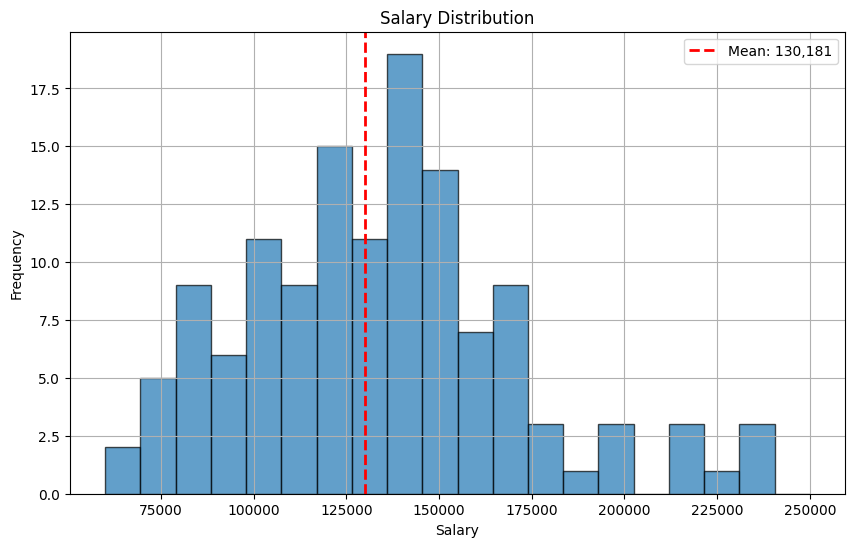

In [469]:
# 60 - 250
salary_df['salary'].hist(bins = 20, range=(60000,250000), edgecolor='black', alpha=0.7, figsize=(10, 6))
avg_salary = salary_df['salary'].mean()

plt.axvline(avg_salary, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_salary:,.0f}')

plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.title("Salary Distribution")

plt.legend(loc='upper right')

plt.show()

In [470]:
salary_yoe_df = salary_df[salary_df['yoe'].notna()].reset_index(drop=True)
#jobs_df['yoe'] = jobs_df['yoe'].astype(int)
salary_yoe_df['yoe'].dtype
#salary_yoe_df.head(10)

# plt.figure(figsize=(8, 6))
# plt.scatter(jobs_df['yoe'], jobs_df['salary'], color='blue', alpha=0.6)
# plt.title('Salary vs Years of Experience')
# plt.xlabel('Years of Experience')
# plt.ylabel('Salary')
# plt.grid(True)
# plt.show()

dtype('O')